<details>
<summary><b>Notebook cells</b></summary>


In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.dpi'] = 150      # crisper PNGs

In [102]:
CSV = 'shoulder_eval.csv'      # adjust file name if needed

df = (
    pd.read_csv(CSV)                            # ❶ read
      .rename(columns={'manualLabel': 'manual_score'})   # ❷ rename once
      .dropna(subset=['manual_score'])          # ❸ keep rows with label
)

print('Loaded', len(df), 'images')
df.head()

Loaded 121 images


,file,manual_score,horizontal_score,abs_error,shoulderTilt
0,3af2910e-a1b9-4974-a816-28e1e918ba85,0.7,0.8028,0.102795,0.8207
1,5ce54831-bd08-4d35-b362-483bba437c4e,0.5,0.4911,0.008861,0.9806
2,53a2428e-3762-4139-af6c-48d123734719,1.0,0.9224,0.077552,0.9757
3,c6423047-ffda-4495-b8ef-f67093ca1a22,1.0,0.9901,0.009888,0.9542
4,c766e0e5-a025-4fbe-ab61-78c218b96549,0.7,0.5694,0.130612,0.9459


In [103]:
rho  = df.manual_score.corr(df.horizontal_score)
mae  = np.abs(df.manual_score - df.horizontal_score).mean()
rmse = np.sqrt(((df.manual_score - df.horizontal_score)**2).mean())

print(f'Pearson ρ   = {rho:.3f}')
print(f'MAE         = {mae:.3f}')
print(f'RMSE        = {rmse:.3f}')

Pearson ρ   = 0.801
MAE         = 0.099
RMSE        = 0.162


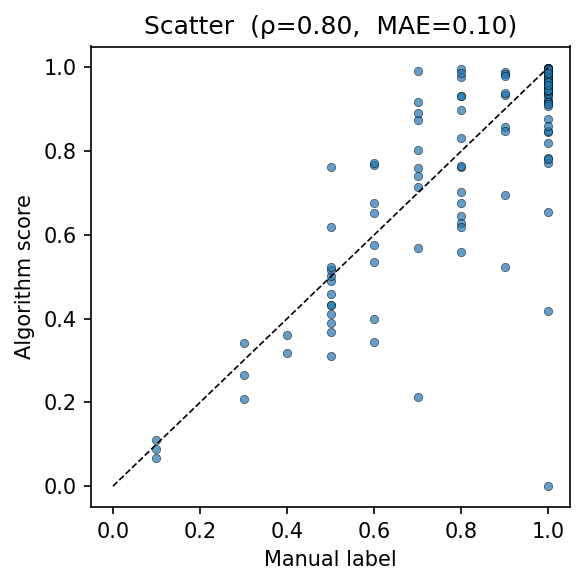

In [104]:
plt.figure(figsize=(4,4))
plt.scatter(df.manual_score, df.horizontal_score,
            s=16, alpha=.7, linewidth=.3, edgecolor='k')
plt.plot([0,1], [0,1], 'k--', lw=.8)
plt.xlabel('Manual label'); plt.ylabel('Algorithm score')
plt.title(f'Scatter  (ρ={rho:.2f},  MAE={mae:.2f})')
plt.tight_layout()
plt.savefig('scatter.png', dpi=300)
plt.show()

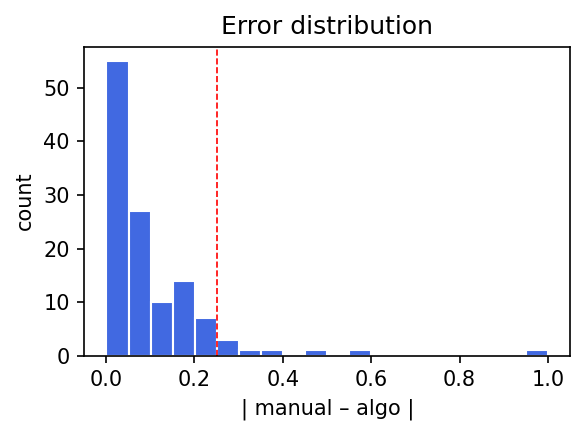

In [105]:
df['abs_error'] = np.abs(df.manual_score - df.horizontal_score)

plt.figure(figsize=(4,3))
plt.hist(df.abs_error, bins=20, color='royalblue', edgecolor='white')
plt.axvline(.25, ls='--', c='red', lw=.8)
plt.xlabel('| manual – algo |'); plt.ylabel('count')
plt.title('Error distribution')
plt.tight_layout()
plt.savefig('hist.png', dpi=300)
plt.show()

In [106]:
thr = 0.80                                   # ISO “square” threshold

gt_pass  = df.manual_score    >= thr
alg_pass = df.horizontal_score >= thr

tp = int(( alg_pass &  gt_pass).sum())
fp = int(( alg_pass & ~gt_pass).sum())
fn = int((~alg_pass &  gt_pass).sum())
tn = int((~alg_pass & ~gt_pass).sum())

fpr = fp / (fp + tn) if (fp + tn) else 0
fnr = fn / (fn + tp) if (fn + tp) else 0

print(f'TP={tp}  FP={fp}  FN={fn}  TN={tn}')
print(f'FPR={fpr:.2%}   FNR={fnr:.2%}')

TP=66  FP=5  FN=16  TN=34
FPR=12.82%   FNR=19.51%


In [107]:
# ╔════════════════ 7.  Build EDC x-y arrays ═════════════════╗
thr = 0.80                                   # ISO “square” threshold

# sort by predicted quality (worst first → discarded first)
df_edc  = df.sort_values('horizontal_score').reset_index(drop=True)

# Boolean vectors
gt_pass  = (df_edc['manual_score']      >= thr).to_numpy(bool)
alg_pass = (df_edc['horizontal_score']  >= thr).to_numpy(bool)

tot = len(df_edc)

# cumulative TP / FN counts *from the tail*  (vectorised: no Python loops)
tp_rev = ( alg_pass &  gt_pass)[::-1].cumsum()[::-1]
fn_rev = (~alg_pass &  gt_pass)[::-1].cumsum()[::-1]

tp   = np.append(tp_rev, 0)           # one extra point at 100 % discarded
fn   = np.append(fn_rev, 0)

disc = np.arange(tot+1) / tot         # x-axis: fraction discarded   (0…1)
# y-axis: FNMR on survivors  ── silence 0/0 warnings
with np.errstate(invalid='ignore', divide='ignore'):
    fnmr = np.where(tp + fn > 0, fn / (tp + fn), 0.0)

print('EDC arrays →', disc.shape, fnmr.shape)

EDC arrays → (122,) (122,)


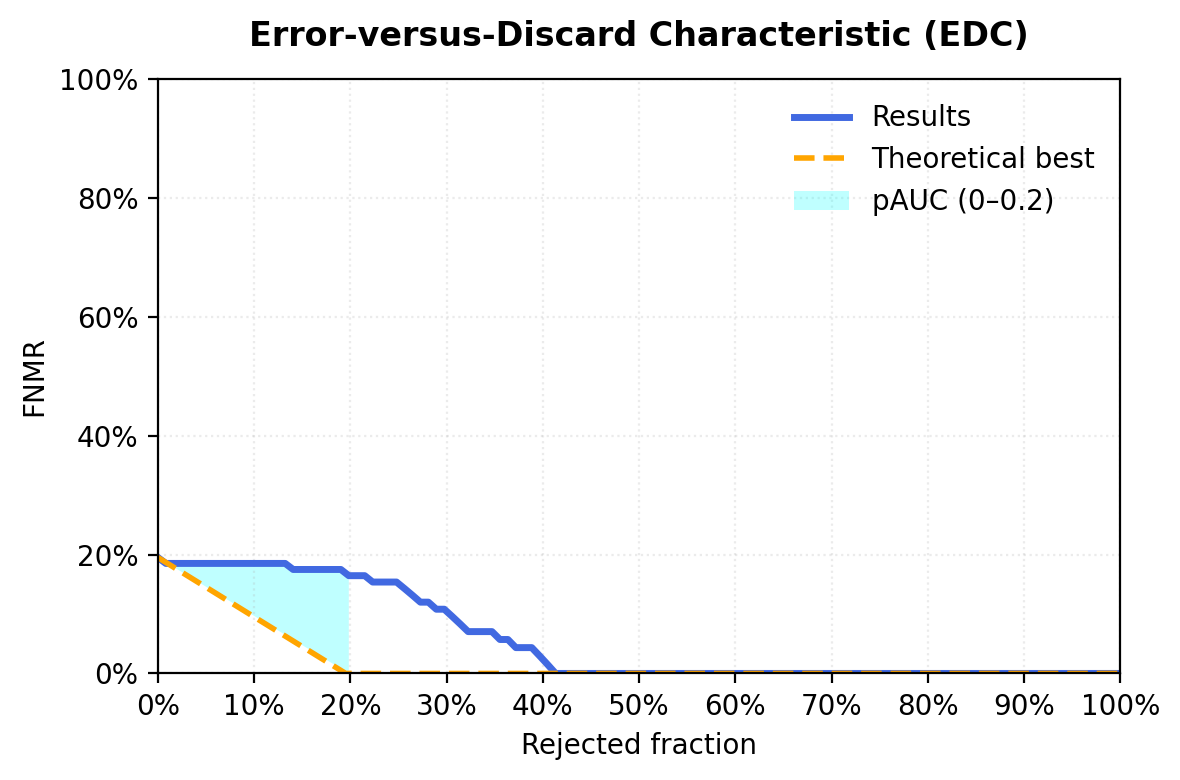

In [108]:
# ╔══════════════ 8.  Pretty EDC figure ══════════════╗
from matplotlib.patches import Polygon
from matplotlib.ticker  import PercentFormatter
import matplotlib.pyplot as plt
import numpy as np      # ← NEW (needed only if not imported earlier)

fig, ax = plt.subplots(figsize=(6, 4), dpi=200)

# ❶ empirical curve
ax.plot(disc, fnmr, lw=2.5, color='royalblue', label='Results')

# ❷ oracle: drop to zero once the discarded fraction equals FNMR₀
fnmr0    = fnmr[0]                      # initial error (≈ 0.20 in your set)
x_oracle = [0, fnmr0, 1]                # 0 % … 100 % discarded
y_oracle = [fnmr0, 0,    0]
ax.plot(x_oracle, y_oracle, ls='--', lw=2, color='orange',
        label='Theoretical best')

# ❸ cyan wedge = pAUC (0–20 % discard)
cut  = disc <= 0.20
poly = np.column_stack((disc[cut], fnmr[cut]))
poly = np.vstack(([0, fnmr0], poly, [disc[cut][-1], 0]))
ax.add_patch(Polygon(poly, facecolor='cyan', alpha=.25, hatch='//',
                     edgecolor='none', label='pAUC (0–0.2)'))

# ─── cosmetics ──────────────────────────────────────────────────────
ax.set_xlabel('Rejected fraction')
ax.set_ylabel('FNMR')
ax.xaxis.set_major_formatter(PercentFormatter(1))
ax.yaxis.set_major_formatter(PercentFormatter(1))

ax.set_xlim(0, 1.0)                # ← NEW: always show full x-range
ax.set_ylim(0, 1.0)                # ← NEW: y-range 0 % … 100 %
ax.set_xticks(np.arange(0, 1.1, 0.1))   # ← NEW: 0 %,10 %,…,100 %
# ax.set_yticks(np.arange(0, 1.1, 0.1)) # optional: explicit y-ticks

ax.set_title('Error-versus-Discard Characteristic (EDC)',
             pad=12, weight='bold')
ax.grid(alpha=.25, linestyle=':')   # ← NEW: dotted grid
ax.legend(frameon=False, loc='upper right')
plt.tight_layout()
plt.savefig('edc_slide.png', dpi=300, transparent=False)
plt.show()